# BOSTON_HOUSING

这次我们要解决的问题是预测波士顿的房价。跟之前的问题不同的是，之前的问题我们预测的结果集都是有限的，比如是数字 0 ~ 9 中的哪一个，评论是正面还是负面，新闻是 46 个品类里的哪一个品类。这种结果集有限的问题被称为**分类问题**。最终需要预测是哪一个分类。但是这次预测波士顿房价的问题不一样，这次需要预测的是房价，结果是一个连续的值。这类问题被称为**回归问题**。

我们使用的数据集是 20 世纪 70 年代的波士顿房价信息数据。数据量比较少，只有 506 个，分为 404 个训练样本，102 个测试样本。与之前的问题不一样的是，输入数据的每个特征的取值范围都不一样。有的是 (0,1)，有的是 (0,100)，还有的是 (1,12)。

# 1、数据集
加载数据

In [3]:
from keras.datasets import boston_housing

(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

我们先看下测试数据的格式

In [7]:
print(train_data.shape)
print(train_data[0])
print(train_targets.shape)
print(train_targets[0])

(404, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
(404,)
15.2


可以看到，我们一共有 404 条训练数据，每一条训练数据又有 13 个特征。输出的标签是房屋价格的中位数，单位是：千美元。比如第一条数据的房屋价格就是 15200 美元。从上面的输出里也可以看到，训练数据的特征取值范围差距非常大。这时因为这些特征代表的含义不同，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。所以对应的取值范围也完全不同。

# 2、数据处理
因为训练数据的特征取值范围不同，如果直接输入到神经网络中，学习会变得困难很多，所以需要先对数据进行**标准化**处理。

**标准化**的过程很简单，拿一条数据来说。首先对这 13 个特征求平均数，所有特征都减去平均数，再除以这 13 个特征的**标准差（方差的算术平方根）** 这样就得到了标准化后的特征了。用 Numpy 很容易实现 **标准化**。

In [10]:
mean = train_data.mean(axis = 0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


print(train_data.shape)
print(train_data[0])

(404, 13)
[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


标准化后的数据都是介于 (-1,1) 之间的数值了。

# 3、构建神经网络

由于数据量比较少，所以我们构建了一个 3 层的神经网络，前两层有 64 个神经单元，最后一层要输出一个具体的数值（房价），所以只有一个神经单元。

![BOSTON_HOUSING_01.png](./resources/BOSTON_HOUSING_01.png)

In [12]:
from keras import models
from keras import layers

def bulid_model():
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(13,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))

    # 编译网络
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

神经网络的最后一层只有一个神经单元，并且没有激活函数，这是**标量回归**的典型设置。因为设置了激活函数后，就会限制输出的范围。这次我们使用了一个新的损失函数 mse，即**均方误差**。计算的是预测值和目标值之间误差的平方。这是回归问题常用的损失函数。我们还使用了一个新的监控指标，mae，即平均绝对误差。它是预测值与目标值之差的绝对值。比如，mae= 1.5 说明预测值与目标值差 1.5。因为我们房价的单位是 千美元，也就是说我们预测的房间与实际的房价差 1500 美元。 

# 4、K折交叉验证
因为数据量比少，导致我们的验证集非常小。因此，验证分数会有很大的波动，无法对模型进行可靠的评估。在这种情况下可以使用 **K折交叉验证**的方法。

这种方法是将数据划分为 K 个分区（通常是 4 或者 5 个）。然后实例化 K 个相同的模型，在 K - 1 个分区上训练，在剩下的一个分区上验证，最后取 K 个模型的验证分数的平均值。

![BOSTON_HOUSING_02.png](./resources/BOSTON_HOUSING_02.png)

In [17]:
import numpy as np

def fit():
    k = 4
    # 每个分区的数据个数
    num_val_samples = len(train_data)//k
    # 循环次数
    num_epochs = 100
    # 所有分数的列表
    all_scores = []

    for i in range(k):
        print("开始训练第 {} 个分区".format(i))
        # 准备验证数据
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_traget = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # 准备训练数据，concatenate方法可以合并数组
        partial_train_data = np.concatenate([train_data[0:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]],axis = 0)

        partial_train_target = np.concatenate([train_targets[0:i * num_val_samples],
                                             train_targets[(i + 1) * num_val_samples:]],axis = 0)
        # 构建神经网络
        model = bulid_model()
        # 开始训练 verbose =0 表示不再输出训练期间的日志信息，因为训练轮次太多。
        model.fit(partial_train_data,partial_train_target,epochs=num_epochs,batch_size = 1,verbose=0)
        # 验证数据
        val_mse,val_mae = model.evaluate(val_data,val_traget,verbose=0)
        # mae 是预测值与实际值的差值
        all_scores.append(val_mae)

    print(all_scores)

fit()

开始训练第 0 个分区
开始训练第 1 个分区
开始训练第 2 个分区
开始训练第 3 个分区
[2.0343523025512695, 2.7967753410339355, 2.6975393295288086, 2.506871461868286]


可以看到 4 个分区的平均值在2.0 到 2.7 之间，差距还是有点大。我们修改循环次数到 500 ，并且保存每轮的验证分数。

In [22]:
# 所有分数的列表
all_scores = []
def fit_02():
    k = 4
    # 每个分区的数据个数
    num_val_samples = len(train_data)//k
    # 循环次数
    num_epochs = 500


    for i in range(k):
        print("开始训练第 {} 个分区".format(i))
        # 准备验证数据
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_traget = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        # 准备训练数据，concatenate方法可以合并数组
        partial_train_data = np.concatenate([train_data[0:i * num_val_samples],
                                             train_data[(i + 1) * num_val_samples:]],axis = 0)

        partial_train_target = np.concatenate([train_targets[0:i * num_val_samples],
                                             train_targets[(i + 1) * num_val_samples:]],axis = 0)
        # 构建神经网络
        model = bulid_model()
        # 开始训练 verbose =0 表示不再输出训练期间的日志信息，因为训练轮次太多。
        history = model.fit(partial_train_data,partial_train_target,epochs=num_epochs,batch_size = 1,verbose=0)
        all_scores.append(history.history['mae'])

fit_02()

开始训练第 0 个分区
开始训练第 1 个分区
开始训练第 2 个分区
开始训练第 3 个分区


我们需要计算每个折MAE的平均值。 ```all_scores``` 是一个 4 行 500 列的二维数组，每一行是 K 折的的验证分数，因为我们训练了 500 次，所以有 500 列。我们需要计算每一次循环时这 4个模型得到的验证分数的平均值，作为模型的验证分数。也就是说，每一列计算一个平均值，作为模型一次循环的验证分数。

In [32]:
# 每一列计算一次平均值。
average_mae_histpry = [np.mean( [x[i] for x in all_scores ]) for i in range(500)]

我们画图展示一下。

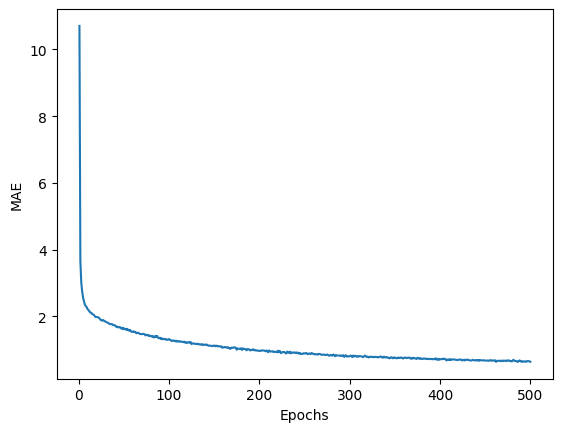

In [38]:
import matplotlib.pyplot as plt

def show(data):
    plt.plot(range(1,len(data)+1),data)
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.show()

show(average_mae_histpry)

上面的图表示，我们的模型在每一次循环时得到的平均验证分数，一共循环了500次。